# Imports

In [1]:
!pip install av torchvision --upgrade


Sanity Check

In [2]:
from torchvision.io.video import read_video

test_path = "/content/drive/MyDrive/CMSC498K/FinalProject/data/train/video"
import os
test_file = os.listdir(test_path)[0]
print("Testing:", test_file)

video, _, _ = read_video(os.path.join(test_path, test_file))
print("SUCCESS:", video.shape)


Testing: 20150912_1445_Everton_3_1_Chelsea_half1_clip_0284.mkv


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/video.py:199: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


SUCCESS: torch.Size([264, 224, 398, 3])


In [3]:
import json
import os
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision.io import read_video
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Dataset

In [4]:
class SoccerVideoDataset(Dataset):
    def __init__(self, root, clip_json_path, num_frames=32, augment=False):
        self.root = Path(root)
        self.num_frames = num_frames
        self.augment = augment

        with open(clip_json_path, "r") as f:
            self.clips = json.load(f)

        self.base_transform = transforms.Compose([
            transforms.Resize((112, 112)),  # R3D-18 input size
            transforms.Normalize(mean=[0.45, 0.45, 0.45],
                                 std=[0.225, 0.225, 0.225])
        ])

        self.augment_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.05, 0.05, 0.05, 0.02),  # subtle color changes
            transforms.GaussianBlur(3)
        ])

    def __len__(self):
        return len(self.clips)

    def _temporal_downsample(self, video):
        T = video.shape[1]
        idxs = torch.linspace(0, T-1, steps=self.num_frames).long()
        return video[:, idxs, :, :]

    def __getitem__(self, idx):
        item = self.clips[idx]

        video_path = item["video"]
        start_ms, end_ms = item["start_ms"], item["end_ms"]

        video, _, _ = read_video(video_path, start_pts=start_ms/1000, end_pts=end_ms/1000, pts_unit="sec")
        video = video.permute(3, 0, 1, 2).float() / 255.0
        video = self._temporal_downsample(video)

        C, T, H, W = video.shape
        frames = []

        for t in range(T):
            frame = video[:, t, :, :]
            if self.augment:
                frame = self.augment_transforms(frame)
            frame = self.base_transform(frame)
            frames.append(frame)

        video = torch.stack(frames, dim=1)
        label = torch.tensor(item["highlight"], dtype=torch.float32)
        return video, label

# Create Dataloaders

In [5]:
base = "/content/drive/MyDrive/CMSC498K/FinalProject/data"

train_ds = SoccerVideoDataset(f"{base}/train", f"{base}/train/clips.json", augment=True)
val_ds = SoccerVideoDataset(f"{base}/val", f"{base}/val/clips.json")
test_ds = SoccerVideoDataset(f"{base}/test", f"{base}/test/clips.json")

# Weighted sampler to handle class imbalance
labels = [item["highlight"] for item in train_ds.clips]
class_counts = [labels.count(0), labels.count(1)]
weights = [1.0/class_counts[label] for label in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=4, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2)

# Define R3D-18 Model

In [6]:
def build_model():
    model = torchvision.models.video.r3d_18(weights="DEFAULT")

    # Freeze only the first 2 layers
    child_counter = 0
    for child in model.children():
        child_counter += 1
        if child_counter <= 2:
            for param in child.parameters():
                param.requires_grad = False

    # Final layer for binary classification
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

model = build_model().cuda()

# Weighted BCE
pos_weight = torch.tensor([class_counts[0]/class_counts[1]]).cuda()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth


100%|██████████| 127M/127M [00:00<00:00, 199MB/s]


# Training Loop

In [7]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    for videos, labels in tqdm(loader):
        videos = videos.cuda()
        labels = labels.cuda().unsqueeze(1)

        optimizer.zero_grad()
        logits = model(videos)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()

        preds = (torch.sigmoid(logits) > 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    return total_loss / len(loader), train_acc

# Validation Loop

In [8]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for videos, labels in loader:
            videos = videos.cuda()
            labels = labels.cuda().unsqueeze(1)

            logits = model(videos)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

# Full Training Script

In [ ]:
save_path = "/content/drive/MyDrive/CMSC498K/FinalProject/r3d18_highlight_model.pth"

num_epochs = 6
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc : {val_acc:.4f}")

torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

  0%|          | 0/778 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
100%|██████████| 778/778 [21:54<00:00,  1.69s/it]
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserW

Epoch 1/6
  Train Loss: 1.3766 | Train Acc: 0.6953
  Val Loss  : 1.0627 | Val Acc : 0.5798


  0%|          | 0/778 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
100%|██████████| 778/778 [20:21<00:00,  1.57s/it]
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserW

Epoch 2/6
  Train Loss: 0.9179 | Train Acc: 0.7711
  Val Loss  : 1.1435 | Val Acc : 0.7018


  0%|          | 0/778 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
100%|██████████| 778/778 [20:05<00:00,  1.55s/it]
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserW

Epoch 3/6
  Train Loss: 0.7706 | Train Acc: 0.8284
  Val Loss  : 1.5916 | Val Acc : 0.7545


  0%|          | 0/778 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
100%|██████████| 778/778 [19:37<00:00,  1.51s/it]
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserW

Epoch 4/6
  Train Loss: 0.6457 | Train Acc: 0.8589
  Val Loss  : 1.4090 | Val Acc : 0.7123


  0%|          | 0/778 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
100%|██████████| 778/778 [19:53<00:00,  1.53s/it]
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserW

Epoch 5/6
  Train Loss: 0.6068 | Train Acc: 0.8769
  Val Loss  : 2.2147 | Val Acc : 0.7530


  0%|          | 0/778 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
100%|██████████| 778/778 [19:46<00:00,  1.53s/it]
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserW

Epoch 6/6
  Train Loss: 0.5087 | Train Acc: 0.8975
  Val Loss  : 1.7958 | Val Acc : 0.7274
Model saved to /content/drive/MyDrive/CMSC498K/FinalProject/r3d18_highlight_model.pth


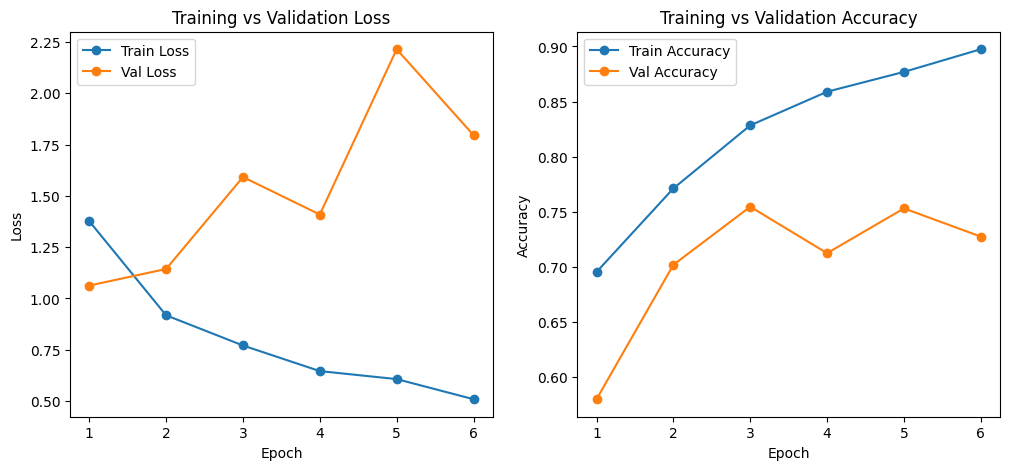

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)   # <-- fix here

plt.figure(figsize=(12,5))

# ------- LOSS CURVE -------
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.xticks(epochs)   # show 1..num_epochs
plt.legend()

# ------- ACCURACY CURVE -------
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Accuracy", marker="o")
plt.plot(epochs, val_accs, label="Val Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xticks(epochs)   # show 1..num_epochs
plt.legend()

plt.show()


# Running Prediction on Test Set

In [ ]:
save_path = "/content/drive/MyDrive/CMSC498K/FinalProject/CNNTraining/r3d18_highlight_model.pth"

model = build_model().cuda()
model.load_state_dict(torch.load(save_path))
model.eval()

criterion = nn.BCEWithLogitsLoss()

all_preds, all_labels = [], []
test_loss = 0
count = 0

with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.cuda()
        labels = labels.cuda().unsqueeze(1)

        logits = model(videos)
        loss = criterion(logits, labels)
        test_loss += loss.item()
        count += 1

        preds = (torch.sigmoid(logits) > 0.5).long()

        all_preds.extend(preds.cpu().view(-1).tolist())
        all_labels.extend(labels.cpu().view(-1).tolist())

test_loss /= count

from sklearn.metrics import classification_report
print(f"Test Loss: {test_loss:.4f}\n")
print(classification_report(all_labels, all_preds, digits=4))



/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


Test Loss: 0.6091

              precision    recall  f1-score   support

         0.0     0.8648    0.8368    0.8506       619
         1.0     0.4326    0.4873    0.4583       158

    accuracy                         0.7658       777
   macro avg     0.6487    0.6621    0.6545       777
weighted avg     0.7769    0.7658    0.7708       777



/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


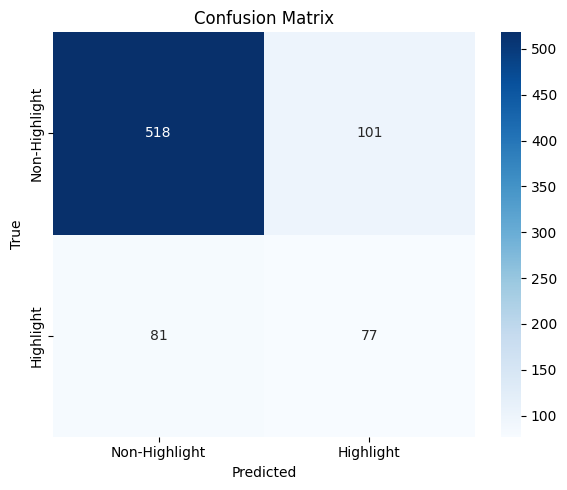

In [9]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

save_path = "/content/drive/MyDrive/CMSC498K/FinalProject/CNNTraining/r3d18_highlight_model.pth"

model = build_model().cuda()
model.load_state_dict(torch.load(save_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.cuda()
        labels = labels.cuda().unsqueeze(1)

        logits = model(videos)
        preds = (torch.sigmoid(logits) > 0.5).long()

        all_preds.extend(preds.cpu().view(-1).tolist())
        all_labels.extend(labels.cpu().view(-1).tolist())

cm = confusion_matrix(all_labels, all_preds)

class_names = ["Non-Highlight", "Highlight"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
